In [ ]:
from functions import *
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr
from optparse import OptionParser
import matplotlib
matplotlib.use('Agg')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping

%matplotlib inline

#min_max_scaler = MinMaxScaler()
n_iter = 100

chunk = 'S9'
print (chunk)

data, labels, unique_mutations[chunk], aa_seq, mut_list = read_data_all_positions(chunk)

print 'Splitting the data'
x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size = 0.05)

n_neurons = []

mse_val = []
mse_train = []
r_val=[]
r_train=[]

r2_weights = []

for i in range(1,11):
    
    print '\nNumber of weights combinations = ', i
    temp_mse_train_list=[]
    temp_mse_val_list=[]
    temp_r_train_list=[]
    temp_r_val_list=[]
    temp_weights_r2={}
    it=0
    loop_count=5
    
    while it<loop_count and loop_count<100:
        print it
        model = Sequential()

        model.add(Dense(i,input_dim=data.shape[1],activation='sigmoid',kernel_initializer='glorot_normal'))
        model.add(Dense(20,activation='sigmoid'))
        model.add(Dense(1,activation='relu'))

        opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)
        
        early_stopping_monitor=EarlyStopping(patience=10)
        
        model.compile(optimizer=opt,
                      loss='mean_squared_error')

        hist = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                                epochs=n_iter, batch_size=500, shuffle=True, callbacks=[early_stopping_monitor],verbose=1)

        proba = model.predict_proba(x_valid, batch_size=500,verbose=0)
        predicted_val = proba.flatten()

        proba = model.predict_proba(x_train, batch_size=500,verbose=0)
        predicted_train = proba.flatten()
        
        weights = model.layers[0].get_weights()[0]
        
        temp_mse_val = mean_squared_error(y_valid,predicted_val)
        temp_mse_train = mean_squared_error(y_train,predicted_train)
        temp_r_val = pearsonr(y_valid,predicted_val)[0]
        temp_r_train = pearsonr(y_train,predicted_train)[0]
        
        it+=1
        
        #Sanity checks
        if temp_mse_val<0.3:
            temp_mse_val_list.append(temp_mse_val)
            temp_mse_train_list.append(temp_mse_train)
            temp_r_val_list.append(temp_r_val)
            temp_r_train_list.append(temp_r_train)
            
            for combination in list(itertools.combinations([x for x in range(i)], 2)):
                if combination in temp_weights_r2:
                    temp_weights_r2[combination].extend([spearmanr(weights[:,combination[0]],weights[:,combination[1]])])
                else:
                    temp_weights_r2[combination] = [spearmanr(weights[:,combination[0]],weights[:,combination[1]])]
                    
        else:
            loop_count+=1
                    
                    
    n_neurons.append(i)
    mse_val.append(temp_mse_val_list)
    mse_train.append(temp_mse_train_list)
    r_val.append(temp_r_val_list)
    r_train.append(temp_r_train_list)
    
    if i>1:
        r2_weights.append([np.median(temp_weights_r2[x]) for x in temp_weights_r2])

/nfs/scistore08/kondrgrp/eputints/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


S9
Splitting the data

Number of weights combinations =  1
0
Train on 16008 samples, validate on 843 samples
Epoch 1/100
16008/16008 [==============================] - 1s - loss: 0.2318 - val_loss: 0.2605
Epoch 2/100
16008/16008 [==============================] - 0s - loss: 0.2290 - val_loss: 0.2334
Epoch 3/100
16008/16008 [==============================] - 0s - loss: 0.2278 - val_loss: 0.3129
Epoch 4/100
16008/16008 [==============================] - 0s - loss: 0.2279 - val_loss: 0.2235
Epoch 5/100
16008/16008 [==============================] - 0s - loss: 0.2249 - val_loss: 0.2851
Epoch 6/100
16008/16008 [==============================] - 0s - loss: 0.2249 - val_loss: 0.2648
Epoch 7/100
16008/16008 [==============================] - 0s - loss: 0.2233 - val_loss: 0.2486
Epoch 8/100
16008/16008 [==============================] - 0s - loss: 0.2235 - val_loss: 0.2221
Epoch 9/100
16008/16008 [==============================] - 0s - loss: 0.2228 - val_loss: 0.2304
Epoch 10/100
16008/16008 [=

/nfs/scistore08/kondrgrp/eputints/.local/lib/python2.7/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Train on 16008 samples, validate on 843 samples
Epoch 1/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 2/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 3/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 4/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 5/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 6/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 7/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 8/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 9/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 10/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss

16008/16008 [==============================] - 0s - loss: 0.2216 - val_loss: 0.3050
Epoch 25/100
16008/16008 [==============================] - 0s - loss: 0.2234 - val_loss: 0.2250
Epoch 26/100
16008/16008 [==============================] - 0s - loss: 0.2214 - val_loss: 0.2213
Epoch 27/100
16008/16008 [==============================] - 0s - loss: 0.2220 - val_loss: 0.2332
Epoch 28/100
16008/16008 [==============================] - 0s - loss: 0.2209 - val_loss: 0.2779
Epoch 29/100
16008/16008 [==============================] - 0s - loss: 0.2213 - val_loss: 0.2320
Epoch 30/100
16008/16008 [==============================] - 0s - loss: 0.2209 - val_loss: 0.2766
2
Train on 16008 samples, validate on 843 samples
Epoch 1/100
16008/16008 [==============================] - 0s - loss: 0.2310 - val_loss: 0.2881
Epoch 2/100
16008/16008 [==============================] - 0s - loss: 0.2279 - val_loss: 0.2558
Epoch 3/100
16008/16008 [==============================] - 0s - loss: 0.2271 - val_loss: 0.2

16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 5/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 6/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 7/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 8/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 9/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 10/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 11/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 12/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 13/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 14/100
16008/16008 [======================

16008/16008 [==============================] - 0s - loss: 0.2286 - val_loss: 0.2580
Epoch 3/100
16008/16008 [==============================] - 0s - loss: 0.2255 - val_loss: 0.2878
Epoch 4/100
16008/16008 [==============================] - 0s - loss: 0.2256 - val_loss: 0.3164
Epoch 5/100
16008/16008 [==============================] - 0s - loss: 0.2244 - val_loss: 0.2845
Epoch 6/100
16008/16008 [==============================] - 0s - loss: 0.2261 - val_loss: 0.2417
Epoch 7/100
16008/16008 [==============================] - 0s - loss: 0.2254 - val_loss: 0.2505
Epoch 8/100
16008/16008 [==============================] - 0s - loss: 0.2233 - val_loss: 0.2202
Epoch 9/100
16008/16008 [==============================] - 0s - loss: 0.2240 - val_loss: 0.2836
Epoch 10/100
16008/16008 [==============================] - 0s - loss: 0.2233 - val_loss: 0.2244
Epoch 11/100
16008/16008 [==============================] - 0s - loss: 0.2225 - val_loss: 0.2202
Epoch 12/100
16008/16008 [========================

16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
8
Train on 16008 samples, validate on 843 samples
Epoch 1/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 2/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 3/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 4/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 5/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 6/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 7/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 8/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 9/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Ep

/nfs/scistore08/kondrgrp/eputints/.local/lib/python2.7/site-packages/keras/models.py:998: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


1
Train on 16008 samples, validate on 843 samples
Epoch 1/100
16008/16008 [==============================] - 0s - loss: 0.2391 - val_loss: 0.2377
Epoch 2/100
16008/16008 [==============================] - 0s - loss: 0.2270 - val_loss: 0.3155
Epoch 3/100
16008/16008 [==============================] - 0s - loss: 0.2268 - val_loss: 0.3119
Epoch 4/100
16008/16008 [==============================] - 0s - loss: 0.2258 - val_loss: 0.2217
Epoch 5/100
16008/16008 [==============================] - 0s - loss: 0.2243 - val_loss: 0.2975
Epoch 6/100
16008/16008 [==============================] - 0s - loss: 0.2232 - val_loss: 0.2216
Epoch 7/100
16008/16008 [==============================] - 0s - loss: 0.2239 - val_loss: 0.2979
Epoch 8/100
16008/16008 [==============================] - 0s - loss: 0.2252 - val_loss: 0.2665
Epoch 9/100
16008/16008 [==============================] - 0s - loss: 0.2233 - val_loss: 0.2207
Epoch 10/100
16008/16008 [==============================] - 0s - loss: 0.2230 - val_lo

16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 8/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 9/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 10/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 11/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 12/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 13/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
9
Train on 16008 samples, validate on 843 samples
Epoch 1/100
16008/16008 [==============================] - 0s - loss: 0.2325 - val_loss: 0.2820
Epoch 2/100
16008/16008 [==============================] - 0s - loss: 0.2278 - val_loss: 0.2844
Epoch 3/100
16008/16008 [==============================] - 0s - loss: 0.2275 - val_loss: 0.280

16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 10/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 11/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 12/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 13/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 14/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 15/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 16/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 17/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 18/100
16008/16008 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3441
Epoch 19/100
16008/16008 [=================

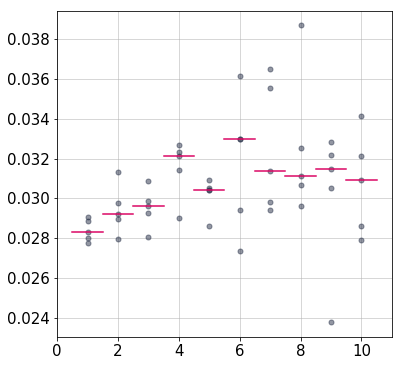

In [2]:
plt.figure(figsize=[6,6])
for i,r_list in enumerate(r_val):
    plt.plot([i+1]*len(r_list),[float(x)**2 for x in r_list],'o',alpha=0.5,color='#283149',ms=5)
    plt.plot([i+0.5,i+1.5],[np.median([float(x)**2 for x in r_list])]*2,'-',color='#DA0463')
plt.grid('--k',lw=0.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/nfs/scistore08/kondrgrp/eputints/Jupyter/HIS3InterspeciesEpistasis/Analysis/Katya/NN/tmp/r2_'+chunk+'.pdf')

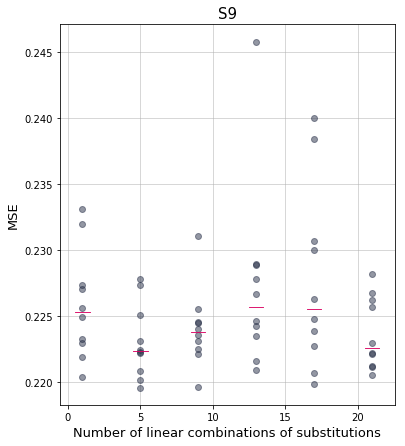

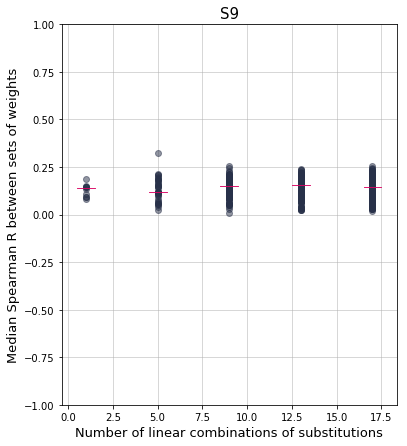

In [22]:
plt.figure(figsize=[6,7])
for i,mse_list in enumerate(mse_val):
    plt.plot([i*4+1]*len(mse_list),mse_list,'o',alpha=0.5,color='#283149')
    plt.plot([i*4+0.5,i*4+1.5],[np.median(mse_list)]*2,'-',lw=0.9,color='#DA0463')
plt.grid('--k',lw=0.5)
plt.title(chunk,fontsize=15)
plt.ylabel('MSE',fontsize=13)
plt.xlabel('Number of linear combinations of substitutions',fontsize=13)
plt.savefig('/nfs/scistore08/kondrgrp/eputints/Jupyter/HIS3InterspeciesEpistasis/Analysis/Katya/NN/complexity/20_iterations/mse_'+chunk+'.pdf')

plt.figure(figsize=[6,7])
for i,r2_list in enumerate(r2_weights):
    plt.plot([i*4+1]*len(r2_list),r2_list,'o',alpha=0.5,color='#283149')
    plt.plot([i*4+0.5,i*4+1.5],[np.median(r2_list)]*2,'-',lw=0.9,color='#DA0463')
plt.ylim(-1,1)
plt.title(chunk,fontsize=15)
plt.grid('--k',lw=0.5)
plt.ylabel('Median Spearman R between sets of weights',fontsize=13)
plt.xlabel('Number of linear combinations of substitutions',fontsize=13)
plt.savefig('/nfs/scistore08/kondrgrp/eputints/Jupyter/HIS3InterspeciesEpistasis/Analysis/Katya/NN/complexity/20_iterations/r2_weights_'+chunk+'.pdf')

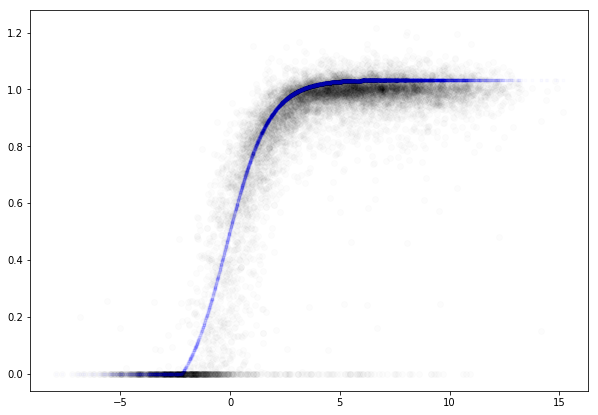

In [52]:
fitness_potential = x_train.dot(weights)+biases
plt.figure(figsize = [10,7])
plt.plot(fitness_potential[:10000], y_train[:10000], 'ok', alpha = 0.01);
plt.plot(fitness_potential[:10000], predicted_train[:10000], '.b', alpha = 0.01);

$F(x) = \sigma(\sum_{i=1}^{20}c_{3,i}\sigma(c_{2,i}\sigma(c_1^Tx + b_1) + b_{2,i}))$